# Data Driven Modeling
<hr style="height:3px;border:none;color:stillblue;background-color:black;" />
### PhD seminar series at Chair for Computer Aided Architectural Design (CAAD), ETH Zurich


[Vahid Moosavi](href=https://vahidmoosavi.com/>)
<hr style="height:1px;border:none;color:stillblue;background-color:black;" />

<a></a>

# Ninth Session 
<hr style="height:1px;border:none;color:stillblue;background-color:steelblue;" />
<span style="color:steelblue;font-size: 1em;"> 29 November 2016</span>


# Markov Chains
## Introduced by Andrei Markov in 1906
![](Images/AAMarkov.jpg)
## His original work on the sequence of charachters in language
## One of the earilest data driven models of the langugae
## Nevertheless, he didn't succeed as his model is data and computation intensive.
## Later it was used extensively to study dynamic (stochastic) systems.
## Recently, it was used as data driven representation approach.


# Therefore, we discuss Markov Chains from the following aspects:

* **From the point of view of dynamical systems**
* **From the point of view of object representation**
* **Properties and applications**
* **Extensions to machine learning applications**

### Topics to be discussed 

* **Text generation with Markov Chains**
* **Markov Chains from the point of view of relational representation**
* **Neuro-probablistic Models of the language**
* ** Natural Language Modeling problems**


In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
pd.__version__
import sys
from scipy import stats
import time
import  pysparse
from scipy.linalg import norm
import sompylib.sompy as SOM

%matplotlib inline

## Generative examples of Markov

# Example of sequence of characters in English texts

In [2]:
with open('./Data/IMDB_data/pos.txt','r') as infile:
    reviews = infile.readlines()
len(reviews)

25000

In [3]:
reviews[0]

'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!\n'

In [4]:
def cleanText(corpus):
    import string
    validchars = string.ascii_letters + string.digits + ' '
    punctuation = """.,:;?!@(){}[]$1234567890"""
    corpus = [z.lower().replace('\n','') for z in corpus]
    corpus = [z.replace('<br />', ' ') for z in corpus]
    
    for c in punctuation:
        corpus =[z.replace(c, '') for z in corpus]
    

    corpus = [''.join(ch for ch in z if ch in validchars) for z in corpus]
    
    #treat punctuation as individual words
    for c in punctuation:
        corpus = [z.replace(c, ' %s '%c) for z in corpus]
#     corpus = [z.split() for z in corpus]
    corpus = [z.replace(' ', '_') for z in corpus]
    return corpus


In [5]:
texts  = cleanText(reviews)

In [6]:
texts[0]

'bromwell_high_is_a_cartoon_comedy_it_ran_at_the_same_time_as_some_other_programs_about_school_life_such_as_teachers_my__years_in_the_teaching_profession_lead_me_to_believe_that_bromwell_highs_satire_is_much_closer_to_reality_than_is_teachers_the_scramble_to_survive_financially_the_insightful_students_who_can_see_right_through_their_pathetic_teachers_pomp_the_pettiness_of_the_whole_situation_all_remind_me_of_the_schools_i_knew_and_their_students_when_i_saw_the_episode_in_which_a_student_repeatedly_tried_to_burn_down_the_school_i_immediately_recalled__at__high_a_classic_line_inspector_im_here_to_sack_one_of_your_teachers_student_welcome_to_bromwell_high_i_expect_that_many_adults_of_my_age_think_that_bromwell_high_is_far_fetched_what_a_pity_that_it_isnt'

In [7]:
all_chars = '_abcdefghijklmnopqrstuvwxyz'
dictionary = {}
for i in range(len(all_chars)):
    dictionary[all_chars[i]] = i
dictionary

{'_': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [8]:
# building data with the format of sequence
data = []
for text in texts[:]:
    d = []
    for c in text:
        d.append(dictionary[c])
    data.append(d)
print len(data)

25000


In [9]:
def buildTM_from_sequential_data(data,states,irreducible=True):
    # each row is a sequence of observation
    n = len(states)
    M = np.zeros((n,n))
    for d in data:
        for k in range(1,len(d)):
            i = d[k-1]
            
            j = d[k]
            M[i,j]= M[i,j] + 1
    
    eps = .001
    for i in range(M.shape[0]):
        s= sum(M[i])
        
        if s==0:
            if irreducible==True:
                M[i]=eps
                M[i,i]=1.
                s= sum(M[i])
                M[i]=np.divide(M[i],s)
            else:
                M[i,i]=1.
        else:
            M[i]=np.divide(M[i],s)    
    return M


# Power iteration Method
def simulate_markov(TM,verbose='on'):
    e1 = time.time()
    states_n = TM.shape[0]
    pi = np.ones(states_n);  pi1 = np.zeros(states_n);
    pi = np.random.rand(states_n)
   
    pi = pi/pi.sum()
    n = norm(pi - pi1); i = 0;
    diff = []
    while n > 1e-6 and i <1*1e4 :
        pi1 = TM.T.dot(pi).copy()
        n = norm(pi - pi1); i += 1
        diff.append(n)
        pi = pi1.copy()
    if verbose=='on':
        print "Iterating {} times in {}".format(i, time.time() - e1)
    
    mixing_ = i
    return pi1,mixing_

In [10]:
states = np.unique(dictionary.values())
M_char = buildTM_from_sequential_data(data,states,irreducible=True)

In [11]:
chars = np.asarray([c for c in all_chars])

## steady state probabilites : equal to the frequencies of characters

Iterating 13 times in 0.000757932662964


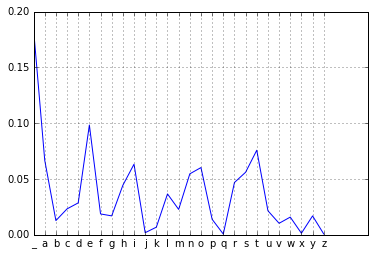

In [12]:
pi,mixing_ = simulate_markov(M_char,verbose='on')
plt.plot(pi);
plt.xticks(range(27),chars);
plt.grid()

# Markov chain as a generative model?!!
## What is the next probable characters for a give charachter

In [13]:
# To see if we can generate something
n_state = M_char.shape[0]
ind_initial = np.random.randint(0,n_state,size=1)
print chars[ind_initial[0]]
ind = ind_initial[0]
for i in range(20):

    
    # If we take the most likely next chars, it quickly falls in a loop?!!
    ind = np.argmax(M_char[ind])
    
    
    # If we take the next char based on a random choice based on the probabilites 
#     ind = np.random.choice(range(M_char.shape[0]),size=1,p=M_char[ind])[0]
    
    print chars[ind]

e
_
t
h
e
_
t
h
e
_
t
h
e
_
t
h
e
_
t
h
e


In [14]:
# To see if we can generate something
n_state = M_char.shape[0]
ind_initial = np.random.randint(0,n_state,size=1)
print chars[ind_initial[0]]
ind = ind_initial[0]
for i in range(20):

    
#     If we take the most likely next chars, it quickly falls in a loop?!!
#     ind = np.argmax(M_char[ind])
    
    
    # If we take the next char based on a random choice based on the probabilites 
    ind = np.random.choice(range(M_char.shape[0]),size=1,p=M_char[ind])[0]
    
    print chars[ind]

s
_
a
r
o
n
o
n
s
_
w
a
t
o
_
e
r
e
_
w
a


## at the char level, it is highly unlikely to expect something interesting

# World level Markov chain
## with more depth: higher order Markov chains

In [16]:
# codes from https://github.com/codebox/markov-text
import sys

sys.path.insert(0, './markovtext')

from db import Db
from gen import Generator
from parse import Parser
from sql import Sql
from rnd import Rnd
import sys
import sqlite3
import codecs





SENTENCE_SEPARATOR = '.'
WORD_SEPARATOR = ' '

args = ['','gen','IMDB2','2']

if (len(args) < 3):
	raise ValueError(usage)
mode  = 'gen'
name  = './markovtext/IMDB_N2'
count = 4


if mode == 'parse':
    
    depth = 2
    file_name = './Data/IMDB_data/pos.txt'

    db = Db(sqlite3.connect(name + '.db'), Sql())
    db.setup(depth)

    txt = codecs.open(file_name, 'r', 'utf-8').read()
    Parser(name, db, SENTENCE_SEPARATOR, WORD_SEPARATOR).parse(txt)

elif mode == 'gen':    
    db = Db(sqlite3.connect(name + '.db'), Sql())
    generator = Generator(name, db, Rnd())
    for i in range(0, count):
        print "{}\n".format(i)
        print generator.generate(WORD_SEPARATOR)
        

else:
	raise ValueError(usage)

0

Ms
1


2

I could be a bad thing? Never Again: It has done out what was still want to changed, or surprises like treasha! Congrats to leave from the grasp some extent
3

My own "Western" (i like a vivid matte how timeless "The Amanda Bynes seems to ensure the Cameron said that most TV I love story of film-making team is my head has hope the film to modify the end we love it looks nice to create a quest for Catwoman (the delicious Paris with a very extensively, it had directed by everyone


# As it can be seen it is far from reasonable
### In fact, the problem of "generative models" is still an open question, unlike "discriminative models"
# So, what can we do with this relational representation?
# <a></a>


# Representation Learning

## Representation of objects based on a priori given features 
### Set theoretical defnition of universals --- > Abstract Universals
![](Images/FeatureBasedRepresentation.jpg)
# Representation of objects based on its context: Relational Representation
### Category theoretical defnition of universals --- > Concrete Universals
![](Images/RelationalRepresentation.jpg)

### This is aslso called Distributional Semantic Models with references to (de Saussure, 1966; Harris, 1951 and Wittgenstein, 1963; Firth, 1957) 
sources from https://www.inf.uni-hamburg.de/en/inst/ab/lt/publications/cogalex-invited-biemann.pdf


## Now when we look at the original idea of Markov in dealing with stochastic systems, it is pure relational 

## This is the case in many applications:
* pixels in an image and their neighboring cells
* A house and its neigborhood
* A person and his friends
* an ingridient in a food recepie
* ...

# co-occurance matrix
### Now if we take each row as the representation of each char, we can assume that we have a proper representation. 
### In fact, we have a matrix form for our data, where each object (e.g. char or a word) is being represented based on its normalized co-occurance matrix 


### Char markov chain

the selected char: i


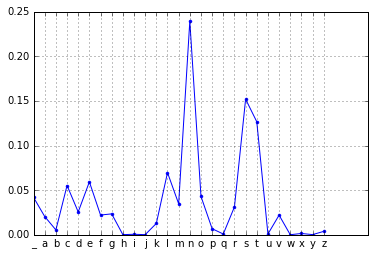

In [17]:
# For each char
ind_initial = np.random.randint(0,n_state,size=1)[0]

print 'the selected char: {}'.format(chars[ind_initial])
plt.plot(range(M_char.shape[0]),M_char[ind_initial],'.-');

plt.xticks(range(M_char.shape[0]),chars);
plt.grid();

### Let's train a SOM with this matrix and see how it works

In [18]:
import sompylib.sompy as SOM

msz11 =20
msz10 = 20

X = M_char

som_char = SOM.SOM('', X, mapsize = [msz10, msz11],norm_method = 'var',initmethod='pca')
# som1 = SOM1.SOM('', X, mapsize = [msz10, msz11],norm_method = 'var',initmethod='pca')
som_char.init_map()
som_char.train(n_job = 1, shared_memory = 'no',verbose='final')
codebook_char = som_char.codebook[:]
codebook_char_n = SOM.denormalize_by(som_char.data_raw, codebook_char, n_method = 'var')


Total time elapsed: 2.790000 secodns
final quantization error: 0.003545


In [19]:
# we projects all the vectors in SOM and visualize it 
xy = som_char.ind_to_xy(som_char.project_data(X))
xy

array([[ 19,  13, 393],
       [ 17,   4, 344],
       [  5,   0, 100],
       [  0,  19,  19],
       [  9,   7, 187],
       [ 19,  19, 399],
       [  5,   9, 109],
       [  6,  16, 136],
       [  0,   9,   9],
       [ 19,   8, 388],
       [  4,  13,  93],
       [  8,   4, 164],
       [ 14,   0, 280],
       [  4,   4,  84],
       [ 14,  14, 294],
       [ 19,   0, 380],
       [  9,   0, 180],
       [ 10,  14, 214],
       [ 12,   4, 244],
       [  9,  19, 199],
       [  4,  19,  99],
       [ 15,   8, 308],
       [  0,   5,   5],
       [  0,  14,  14],
       [ 14,  19, 299],
       [ 11,  10, 230],
       [  0,   0,   0]])

([], <a list of 0 Text yticklabel objects>)

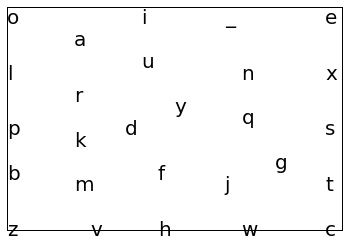

In [20]:
ax = plt.subplot(1,1,1)
for i in range(len(X)):
    plt.annotate(chars[i], (xy[i,1],xy[i,0]),size=20, va="center")
    plt.xlim((0,som_char.mapsize[0]))
    plt.ylim((0,som_char.mapsize[0]))
plt.xticks([])
plt.yticks([])

## In the char model, we can't make sure if it makes sense, maybe at the world level, it works
### Nevertheless, we only represent each chars based on its relation with the next possible chars
### And this means to loose lots of valuable data
![](Images/RelationalMarkov.jpg)

## At the word level, defnitely we get better results, but..

# We will have "state space explosion" with few amount of texts
# Therefore, we need to perform some types of dimensionality reduction. 
### For example, to use PCA or  similar methods (LSA,LDA,SVD,...) to reduce the dimensionality.
# Problems: Scalability and speed, memory,...!

# <a></a>
# <a></a>
# <a></a>


<span style="color:red;font-size: 3em;"> Neural embeddings!</span>
<hr style="height:1px;border:none;color:stillblue;background-color:steelblue;" />
# A game changer idea: do not build the co-occurence matrix explicitly!
### Instead learn a classifier that predicts a word given a context around the word or the other way around.
### (Bengio et al. 2003) and Mikolov et al., 2013 known as Word2vec

### In word2Vec there are two main models
### <center> CBOW </center>
![](Images/CBOW.png)



### <center> Skipgram </center>
![](Images/Skip-gram.png)


* ** We have v unique words**
* **each word is a one-hot v dimensional vector**
* **we have Two matrice: W1(vxn) ,W2(nxv)**
* **n is the dimension we choose (50-1000)**
* **read arrows as dot product**
* ** there is an objective function that implies: given a word the network should predict the contexts and vice versa**
* ** if one can write a parametric objective function, there are usually severalmethods to find an optimum value for it**
* ** In majorty of machine learning methods they use Stochastic Gradient Descent (SGD) along chain rule (we discuss them in detail in one session**
* **After training the W1 has amazing features**

** Details about training: http://www-personal.umich.edu/~ronxin/pdf/w2vexp.pdf**

In [21]:
## Just a hint to Gradient Descent

1.50053826867


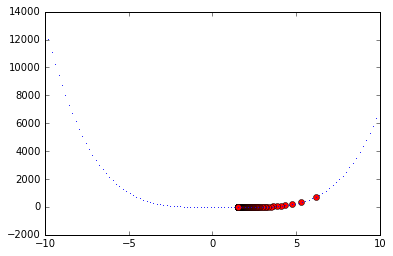

In [22]:
x_old = 0
x_new = 9
eps = .001
precision = .00001

# y = x^2
def f(x):
    return np.power(x,4) -3*np.power(x,3)  + 2

def f_deriv(x):
    return 4*np.power(x,3) - 9*x



counter = 0
while abs(x_old-x_new)>precision:
    x_old = x_new
    x_new = x_old - eps*f_deriv(x_old)
    plt.plot(x_new,f(x_new),'or')
    counter = counter + 1
print x_new 

for x in np.linspace(-10,10,100):
    plt.plot(x,f(x),'.b',markersize=1)

### in principle, in most of machine learning methods, we have a loss function which is differetiable to all the parameters.
### Therefore, using the training data we gradually update the parameters toward a direction that minimizes the loss function

### we will discuss it in more details later on neural networks
### For now let's go back to Word2vec

In [23]:
#### We use a beautiful library called, gensim
import gensim
from gensim import corpora, models, similarities
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [24]:
# from gensim.models import word2vec
# # get the pretrained vector from https://code.google.com/archive/p/word2vec/
# Google_w2v = word2vec.Word2Vec.load_word2vec_format('/Users/SVM/Downloads/GoogleNews-vectors-negative300.bin', binary=True)

In [25]:
# print Google_w2v.most_similar(['girl', 'father'], ['boy'], topn=1)
# print Google_w2v.most_similar(positive=['woman', 'king'], negative=['man'], topn=10)

# What can be done with Word2vec?
## In general the learned densed vectors can be used in any other tasks that require fixed lenght vectors. 
### Some of interesting applications:
* **In Fashion industry:**
    * http://multithreaded.stitchfix.com/blog/2015/03/11/word-is-worth-a-thousand-vectors/
    * http://developers.lyst.com/2014/11/11/word-embeddings-for-fashion/
    * In combination with topic modeling http://www.slideshare.net/ChristopherMoody3/word2vec-lda-and-introducing-a-new-hybrid-algorithm-lda2vec-57135994
* ** Any recommendation system**
    * **music selection considering user's playlists**
    * **Shopping baskets**
* **Graphical data: Deep Walk:**
    * https://sites.google.com/site/bryanperozzi/projects/deepwalk
* **Sentiment Analysis**


# Movie Reviews Sentiment Analysis

In [26]:
%matplotlib inline
from sklearn.cross_validation import train_test_split
from gensim.models.word2vec import Word2Vec
import numpy as np
with open('/All_Files/Files/Data/gensim/sample_Data/IMDB_data/pos.txt', 'r') as infile:
    pos_tweets = infile.readlines()

with open('/All_Files/Files/Data/gensim/sample_Data/IMDB_data/neg.txt', 'r') as infile:
    neg_tweets = infile.readlines()
    
with open('/All_Files/Files/Data/gensim/sample_Data/IMDB_data/unsup.txt','r') as infile:
    unsup_reviews = infile.readlines()

#use 1 for positive sentiment, 0 for negative
y = np.concatenate((np.ones(len(pos_tweets)), np.zeros(len(neg_tweets))))

x_train, x_test, y_train, y_test = train_test_split(np.concatenate((pos_tweets, neg_tweets)), y, test_size=0.5)

#Do some very minor text preprocessing



def cleanText(corpus):
    import string
    validchars = string.ascii_letters + string.digits + ' '
    punctuation = """.,:;@(){}[]$1234567890"""
    corpus = [z.lower().replace('\n','') for z in corpus]
    corpus = [z.replace('<br />', ' ') for z in corpus]
    
    for c in punctuation:
        corpus =[z.replace(c, '') for z in corpus]
    

    corpus = [''.join(ch for ch in z if ch in validchars) for z in corpus]
    
    #treat punctuation as individual words
    for c in punctuation:
        corpus = [z.replace(c, ' %s '%c) for z in corpus]
    corpus = [z.split() for z in corpus]
#     corpus = [z.replace(' ', '_') for z in corpus]
    return corpus


x_train_c = cleanText(x_train)
x_test_c = cleanText(x_test)
unsup_  = cleanText(unsup_reviews)



## Train Word2vec model here

In [75]:
n_dim = 150
#Initialize model and build vocab
imdb_w2v = Word2Vec(size=n_dim, min_count=10,
                    sentences=None, alpha=0.025, window=5, max_vocab_size=None,
                    sample=0, seed=1, workers=6, min_alpha=0.0001, sg=1, hs=1, negative=0, cbow_mean=0,
                    iter=1, null_word=0)


# imdb_w2v.build_vocab(np.concatenate((unsup_,x_train)))
imdb_w2v.build_vocab(x_train_c)

# Train the model over train_reviews (this may take several minutes)
# imdb_w2v.train(np.concatenate((unsup_,x_train)))
imdb_w2v.train(x_train_c)

5535848

In [76]:
print imdb_w2v.most_similar(['good'], topn=5)
# print imdb_w2v.most_similar(positive=['woman', 'king'], negative=['man'], topn=10)

[('decent', 0.6008697748184204), ('great', 0.5777084827423096), ('nice', 0.563409686088562), ('bad', 0.5431483387947083), ('cool', 0.5381938219070435)]


# To make DocVec based on SOMind
### Now the question is how to make prediction at the document level

In [77]:
import pandas as pd
import pandas.io.data
import numpy as np
from matplotlib import pyplot as plt
import sys
from sklearn.preprocessing import scale

pd.__version__

u'0.18.0'

In [78]:
# Here, we have the choice of using ay pretrained model too
Googlevec = 'No'
import gensim


vocablen = len(imdb_w2v.vocab.keys())

# vocablen = len(uniq_from_x_train)

vector_size = imdb_w2v.vector_size
VocabVec = np.zeros((vocablen,vector_size))

vocab = imdb_w2v.vocab.keys()



for i in range(vocablen):
    if Googlevec=='Yes':
        try:
            VocabVec[i] = Google_w2v[vocab[i]]
        except:
            continue
    else:
        try:
            VocabVec[i] = imdb_w2v[vocab[i]]
        except:
            continue
        
print Googlevec 

print 'data size', VocabVec.shape

No
data size (20332, 150)


In [79]:
def buildDocHistogram(Vocab_ind, text, ind_size,normalize='Yes'):
    vec = np.zeros(ind_size).reshape((1, ind_size))
    count = 0.
    for word in text:
        try:
            vec[0,Vocab_ind[word]] += 1
            count += 1.
        except KeyError:
            continue
    if count != 0:
        if normalize=='Yes':
            vec /= count
    return vec

In [80]:
#Build new dim for vocabs based on SOMinds
print 'data size', VocabVec.shape
ind_final_vocab = VocabVec.sum(axis=1)!=0

final_VocabVec = VocabVec[ind_final_vocab]

final_vocab = list(np.asarray(vocab)[ind_final_vocab])
Vocab_Wordind = dict(zip(final_vocab,range(len(final_vocab)) ))

data size (20332, 150)


In [81]:
ind_size = len(final_vocab)
labels = y_train
ind_pos = labels==1
ind_neg = labels==0
all_coocur_ = np.zeros((len(x_train_c),ind_size))
for i in range(len(x_train_c)):
    all_coocur_[i]= buildDocHistogram(Vocab_Wordind, x_train_c[i], ind_size,normalize='No')
all_coocur_  = all_coocur_.sum(axis=0)

print 'all done'
len_neg = len(list(np.asarray(x_train_c)[ind_neg]))
neg_coocur_ = np.zeros((len_neg,ind_size))
for i,text in enumerate(list(np.asarray(x_train_c)[ind_neg])):
    neg_coocur_[i,:]= buildDocHistogram(Vocab_Wordind, text, ind_size,normalize='No')
neg_coocur_  = neg_coocur_.sum(axis=0)

print 'neg done'
len_pos = len(list(np.asarray(x_train_c)[ind_pos]))
pos_coocur_ = np.zeros((len_pos,ind_size))
for i,text in enumerate(list(np.asarray(x_train_c)[ind_pos])):
    pos_coocur_[i,:]= buildDocHistogram(Vocab_Wordind, text, ind_size,normalize='No')
pos_coocur_  = pos_coocur_.sum(axis=0)

print 'pos done'

all done
neg done
pos done


In [82]:
labels = y_train
ind_pos = labels==1
ind_neg = labels==0
#Make the histogram of documents basedo n SOMinds
ind_size = len(final_vocab)


# all_coocur_ = np.concatenate([buildDocHistogram(Vocab_Wordind, z, ind_size,normalize='No') for z in x_train_c])
# pos_coocur_ = np.concatenate([buildDocHistogram(Vocab_Wordind, z, ind_size,normalize='No') for z in list(np.asarray(x_train_c)[ind_pos])])
# neg_coocur_ = np.concatenate([buildDocHistogram(Vocab_Wordind, z, ind_size,normalize='No') for z in list(np.asarray(x_train_c)[ind_neg])])


# #Summing over all texts for each word
# pos_coocur_ = pos_coocur_.sum(axis=0)
# neg_coocur_ = neg_coocur_.sum(axis=0)
# all_coocur_ = all_coocur_.sum(axis=0)

#normalizing the values
# pos_coocur_ = pos_coocur_/all_coocur_
# neg_coocur_ = neg_coocur_/all_coocur_

pos_to_neg = pos_coocur_/(neg_coocur_+1)

sorted_features =pd.DataFrame(index=range(pos_coocur_.shape[0]))
sorted_features['words'] = Vocab_Wordind.keys()
sorted_features['pos_coocur_'] = pos_coocur_
sorted_features['neg_coocur_'] = neg_coocur_
sorted_features['pos_to_neg'] = pos_to_neg
sorted_features['differ'] = np.abs(neg_coocur_-pos_coocur_)
sorted_features = sorted_features.sort_values('differ',ascending=False)
sorted_features.head()

,words,pos_coocur_,neg_coocur_,pos_to_neg,differ
17071,predicted,87764.0,73465.0,1.194621,14299.0
5983,was,171797.0,163184.0,1.052774,8613.0
17619,paddy,76676.0,68766.0,1.115012,7910.0
11015,down,56285.0,49633.0,1.134001,6652.0
11027,annmargret,50111.0,43690.0,1.146941,6421.0


In [83]:
sorted_features.shape

(20332, 5)

In [84]:

###############
###############


### It seems that having all the features is not that bad! Even the results are similar, eventhough it might slow down the 
### som trainig and som projection steps, it dosne't need conditional probabilities to be calculated
sel_features = sorted_features.index[:15000].values
Data= final_VocabVec[sel_features,:]


# sel_features = sorted_features.index[:].values
# Data= final_VocabVec

# len(sel_vocab)


#Train a SOM based on vocabs
# reload(sys.modules['sompy'])
ind_size = 3000
sm1 = SOM.SOM('sm', Data, mapsize = [1,ind_size],norm_method = 'var',initmethod='pca')
# ind_size = 50*50
sm1.train(n_job = 1, shared_memory = 'no',verbose='final')
print 'Training Done'

# sm1.hit_map()
print sm1.codebook.shape

#Remained Data
print sm1.data.shape


#Build new dim for vocabs based on SOMinds
Vocab_Somind = dict(zip(list(np.asarray(final_vocab)[sel_features]), list(sm1.project_data(Data))))
# Vocab_Somind = dict(zip(list(np.asarray(final_vocab)[:]), list(sm1.project_data(Data))))


# Vocab_Somind = dict(zip(final_vocab, list(sm1.project_data(Data))))



Total time elapsed: 153.612000 secodns
final quantization error: 8.289663
Training Done
(3000, 150)
(15000, 150)


In [85]:
DF = pd.DataFrame()
DF['word']=np.asarray(final_vocab)[sel_features]
b = sm1.project_data(Data)
DF['somind'] = b

DF.sort_values('somind')[:10]

,word,somind
1334,ford,0
977,peter,0
2261,l,0
1021,wood,0
1149,holmes,0
1978,jr,0
1205,jim,0
2137,sir,0
11396,williams,0
11322,wayne,0


In [86]:

from sklearn.preprocessing import scale
#Make the histogram of documents basedo n SOMinds
train_vecs = np.concatenate([buildDocHistogram(Vocab_Somind, z, ind_size) for z in x_train_c])
train_vecs = scale(train_vecs)


test_vecs = np.concatenate([buildDocHistogram(Vocab_Somind, z, ind_size) for z in x_test_c])
test_vecs = scale(test_vecs)



In [87]:
# #now select the most informative features (here are sominds, but we can do this on original words too)

# def calc_conditional_feature_importance(corpus_mat,labels):
#     #corpus_mat is the original matrix where each row is one record and columns are features, where are either words or sominds
#     #sentiments are labels
#     #it returns a matrix showing the relative importance of each feature regarding to each label
#     pos_coocur_ = np.zeros((corpus_mat.shape[1],1))
#     neg_coocur_ = np.zeros((corpus_mat.shape[1],1))
#     ind_pos = labels==1
#     ind_neg = labels==0
#     for i in range(corpus_mat.shape[1]):
#         pos_coocur_[i] = np.sum(corpus_mat[ind_pos,i])
#         neg_coocur_[i] = np.sum(corpus_mat[ind_neg,i])
#         sum_ = (pos_coocur_[i]+neg_coocur_[i])
#         if sum_ !=0:
#             pos_coocur_[i] = pos_coocur_[i]/sum_
#             neg_coocur_[i] = neg_coocur_[i]/sum_
        
# #             print i
#     DF =pd.DataFrame(index=range(corpus_mat.shape[1]))
#     DF['pos_coocur_'] = pos_coocur_
#     DF['neg_coocur_'] = neg_coocur_
#     DF['differ'] = np.abs(neg_coocur_-pos_coocur_)
#     DF = DF.sort_values('differ',ascending=False)
#     return DF

# Predictor 
it can be any method

In [91]:
#Use classification algorithm (i.e. Stochastic Logistic Regression) on training set, then assess model performance on test set
from sklearn.linear_model import SGDClassifier
import sklearn.linear_model as lm
lm.RidgeClassifier
from sklearn.decomposition import RandomizedPCA


# howmany = range(10,sm1.nnodes,200)
# # howmany = range(10,15000,500)
# howmany = range(sm1.nnodes,sm1.nnodes+1)
clf = lm.RidgeClassifier()
# from sklearn.neighbors import KNeighborsClassifier
# clf = KNeighborsClassifier(n_neighbors=5)
# clf = lm.SGDClassifier(loss="hinge", alpha=0.01, n_iter=200)

# import sklearn.ensemble as ensemble
# clf = ensemble.RandomForestRegressor(n_jobs=1) 






X_Train = train_vecs[:]
X_Test = test_vecs[:]

# pca = RandomizedPCA(n_components=int(.05*X_Train.shape[1]))
# pca.fit(X_Train)
# X_Train = pca.transform(X_Train)
# X_Test = pca.transform(X_Test)




clf.fit(X_Train, y_train)




import sklearn.metrics as metrics
print metrics.classification_report(y_test,clf.predict(X_Test))

             precision    recall  f1-score   support

        0.0       0.85      0.84      0.85     12542
        1.0       0.84      0.85      0.85     12458

avg / total       0.85      0.85      0.85     25000



## Some extensions
* **Doc2vec**
    * https://arxiv.org/pdf/1405.4053v2.pdf
* **Thought vector: In the same direction in other compression applications**

# One of my previous test application for news analysis
http://todo-vahidmoosavi.rhcloud.com/somnews
